# ORF recognition by CNN

The convolutional neural network (CNN) was invented for image processing.
Here, we use Conv1D layers with filter width=3. 
We have previously seen high accuracy with some overfitting.
Here, apply dropout to reduce overfitting.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-17 13:00:35 UTC'

In [2]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=1000            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 32   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=10  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
print("Train on",len(nc_train),"NC seqs")

Train on 20000 PC seqs
Train on 20000 NC seqs


In [6]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (1000, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 32)          416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten (Flatten)       

In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/10
1000/1000 [==============================] - 78s 77ms/step - loss: 0.6641 - accuracy: 0.5795 - val_loss: 0.5256 - val_accuracy: 0.7410
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/10
1000/1000 [==============================] - 77s 77ms/step - loss: 0.4958 - accuracy: 0.7688 - val_loss: 0.4583 - val_accuracy: 0.7908
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.4016 - accuracy: 0.8285 - val_loss: 0.3984 - val_accuracy: 0.8259
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.2960 - accuracy: 0.8837 - val_loss: 0.3101 - val_accuracy: 0.8763
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/10
1000/1000 [==============================] - 80s 80ms/step - loss: 0.2319 - accuracy: 0.9144 - val_loss: 0.2772 - val_accuracy: 0.8899
INFO:tensorflow:Asse

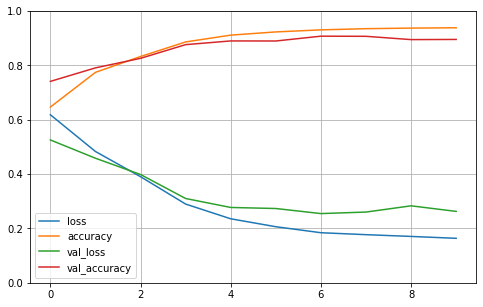

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/10
1000/1000 [==============================] - 78s 77ms/step - loss: 0.6598 - accuracy: 0.5897 - val_loss: 0.5366 - val_accuracy: 0.7347
Epoch 2/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.4994 - accuracy: 0.7663 - val_loss: 0.5020 - val_accuracy: 0.7541
Epoch 3/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.4129 - accuracy: 0.8169 - val_loss: 0.3996 - val_accuracy: 0.8286
Epoch 4/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.3083 - accuracy: 0.8791 - val_loss: 0.3022 - val_accuracy: 0.8804
Epoch 5/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.2298 - accuracy: 0.9177 - val_loss: 0.2592 - val_accuracy: 0.9014
Epoch 6/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.1937 - accuracy: 0.9309 - val_loss: 0.2516 - val_accuracy: 0.9051
Epoch 7/10
1000/1000 [==============================] - 80s 79ms/step - loss: 0.17

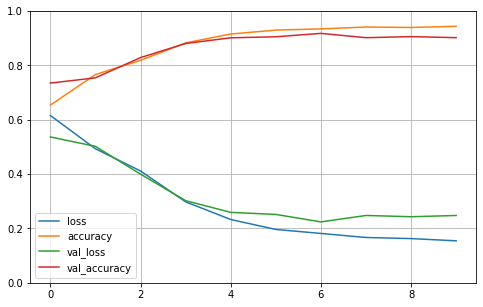

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/10
1000/1000 [==============================] - 76s 75ms/step - loss: 0.6600 - accuracy: 0.5886 - val_loss: 0.5362 - val_accuracy: 0.7312
Epoch 2/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.4885 - accuracy: 0.7718 - val_loss: 0.4964 - val_accuracy: 0.7594
Epoch 3/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.4173 - accuracy: 0.8134 - val_loss: 0.3941 - val_accuracy: 0.8248
Epoch 4/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.3122 - accuracy: 0.8751 - val_loss: 0.3310 - val_accuracy: 0.8591
Epoch 5/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.2481 - accuracy: 0.9063 - val_loss: 0.2910 - val_accuracy: 0.8860
Epoch 6/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.2095 - accuracy: 0.9212 - val_loss: 0.2643 - val_accuracy: 0.9003
Epoch 7/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.18

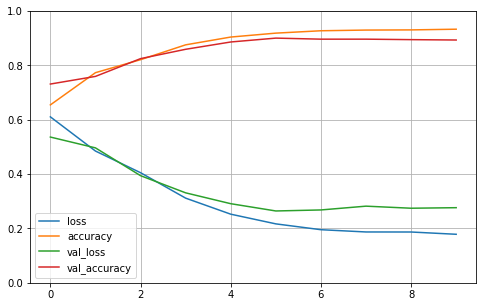

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/10
1000/1000 [==============================] - 79s 78ms/step - loss: 0.6481 - accuracy: 0.6067 - val_loss: 0.5137 - val_accuracy: 0.7564
Epoch 2/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.4809 - accuracy: 0.7781 - val_loss: 0.4927 - val_accuracy: 0.7640
Epoch 3/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.3788 - accuracy: 0.8411 - val_loss: 0.3882 - val_accuracy: 0.8278
Epoch 4/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.2866 - accuracy: 0.8895 - val_loss: 0.3426 - val_accuracy: 0.8497
Epoch 5/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.2400 - accuracy: 0.9083 - val_loss: 0.3140 - val_accuracy: 0.8685
Epoch 6/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.2104 - accuracy: 0.9225 - val_loss: 0.3315 - val_accuracy: 0.8645
Epoch 7/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.20

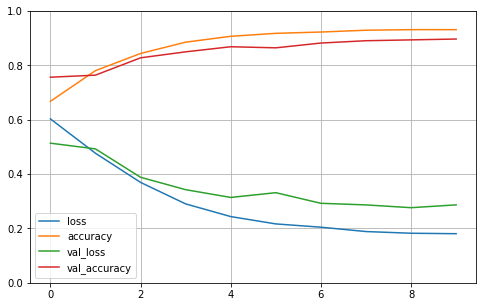

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/10
1000/1000 [==============================] - 77s 76ms/step - loss: 0.6685 - accuracy: 0.5794 - val_loss: 0.5110 - val_accuracy: 0.7540
Epoch 2/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.4980 - accuracy: 0.7633 - val_loss: 0.4208 - val_accuracy: 0.8105
Epoch 3/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.3775 - accuracy: 0.8385 - val_loss: 0.3728 - val_accuracy: 0.8394
Epoch 4/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.3019 - accuracy: 0.8797 - val_loss: 0.3269 - val_accuracy: 0.8597
Epoch 5/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.2445 - accuracy: 0.9066 - val_loss: 0.3126 - val_accuracy: 0.8662
Epoch 6/10
1000/1000 [==============================] - 77s 77ms/step - loss: 0.2062 - accuracy: 0.9266 - val_loss: 0.2722 - val_accuracy: 0.8921
Epoch 7/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.18

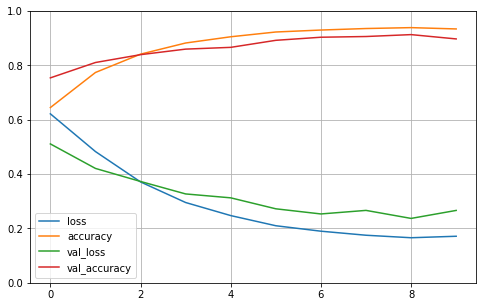

In [9]:
do_cross_validation(X,y)

In [10]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 91.15%


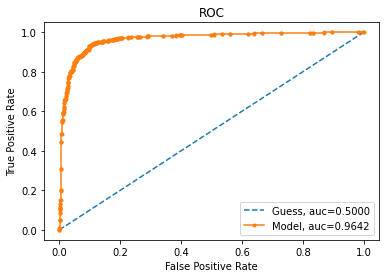

AUC: 0.96%


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [12]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-17 14:06:01 UTC'

## Conclusion
20% dropout may have reduced overfitting by a small amount.
We should try more dropout.